<a href="https://colab.research.google.com/github/nyp-sit/sdaai-pdc2-students/blob/master/iti107/session-9/image_captioning-v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" align="left"/></a>

In this programming exercise, we will develop a CNN/RNN Encoder-Decoder model to perform image captioning. 

At the end of this exercise, you will be able to:
1. understand how CNN can be used in combination with RNN  
2. implement image captioning with attention mechanism

**Note:** You need to run this in tensorflow 2.0 virtual environment.

*Credit: This notebook is adapted from https://www.tensorflow.org/tutorials/text/image_captioning*

Given an image like the example below, our goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](nb_images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

In this notebook, we will use the Flickr8K dataset for training our image caption model. When you run the notebook, it downloads the Flickr8k captions and images dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 6,000 images (because there are 5 captions per image in the dataset).

In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
from tqdm import tqdm
import pickle

## Download and prepare the Flickr8K dataset

You will use the Flickr8K dataset to train our model. The dataset contains 8000 images which are divided into train (6000 images), dev (1000 images) and test set (1000 images). Each image has 5 different caption annotations. The code below downloads and extracts the dataset automatically. The zip file for images is around 2GB. 

The subdirectory *Flickr8k_text* contains the captions file *Flickr8k.token.txt* and the subdirectory *Flickr8k_Dataset* contains the image jpeg files. 

The caption file *Flickr8k.token.txt* contains one caption per line: 

```
1000268201_693b08cb0e.jpg#0     A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1     A girl going into a wooden building .
....
1000268201_693b08cb0e.jpg#4     A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0     A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1     A black dog and a tri-colored dog playing with each other on the road .
....
1001773457_577c3a7d70.jpg#3     Two dogs of different breeds looking at each other on the road .
```

The file *Flickr_8k.trainImages.txt* contains the list of image filenames for training set and *Flickr_8k.devImages.txt* contains image filenames for validation set.

In [2]:
annotation_zip = tf.keras.utils.get_file('Flickr8k_text.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'https://sdaaidata.s3-ap-southeast-1.amazonaws.com/datasets/Flickr8k_text.zip',
                                          extract = True)
annotation_file = os.path.join('Flickr8k_text', 'Flickr8k.token.txt')


In [3]:
name_of_zip = 'Flickr8k_Dataset.zip'

if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
    image_zip = tf.keras.utils.get_file(name_of_zip,
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'https://sdaaidata.s3-ap-southeast-1.amazonaws.com/datasets/Flickr8k_Dataset.zip',
                                      extract = True)

PATH = os.path.join(os.path.abspath('.'),'Flickr8k_Dataset')

In [4]:
# read the list of captions
with open(annotation_file, 'r') as file:
    all_captions_list = file.read().split('\n')

# read the training set of images
train_image_filename = os.path.join('Flickr8k_text','Flickr_8k.trainImages.txt')
with open(train_image_filename, 'r') as file:
    train_image_files_list = file.read().split('\n')
    
# read the validation set of images
val_image_filename = os.path.join('Flickr8k_text','Flickr_8k.devImages.txt')
with open(val_image_filename, 'r') as file:
    val_image_files_list = file.read().split('\n')

Create list of train/validation image_ids and captions

In [5]:
train_image_ids = []
train_captions = []

val_image_ids = []
val_captions = []

for line in all_captions_list:
    tokens = line.split()
    #print(tokens)
    if len(tokens) < 2:
        continue
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id.split('#')[0] in train_image_files_list:
        train_image_ids.append(image_id)
        cap = ' '.join(tokens[1:])
        cap = '<start> ' + cap + ' <end>'
        train_captions.append(cap)
    elif image_id.split('#')[0] in val_image_files_list:
        val_image_ids.append(image_id)
        cap = ' '.join(tokens[1:])
        cap = '<start> ' + cap + ' <end>'
        val_captions.append(cap)


In [6]:
print(train_image_ids[:10:2])
print(train_captions[:10:2])

['1000268201_693b08cb0e.jpg#0', '1000268201_693b08cb0e.jpg#2', '1000268201_693b08cb0e.jpg#4', '1001773457_577c3a7d70.jpg#1', '1001773457_577c3a7d70.jpg#3']
['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A little girl climbing into a wooden playhouse . <end>', '<start> A little girl in a pink dress going into a wooden cabin . <end>', '<start> A black dog and a tri-colored dog playing with each other on the road . <end>', '<start> Two dogs of different breeds looking at each other on the road . <end>']


In [7]:
print(val_image_ids[:10:2])
print(val_captions[:10:2])

['1022454332_6af2c1449a.jpg#0', '1022454332_6af2c1449a.jpg#2', '1022454332_6af2c1449a.jpg#4', '103106960_e8a41d64f8.jpg#1', '103106960_e8a41d64f8.jpg#3']
['<start> A child and a woman are at waters edge in a big city . <end>', '<start> A little boy at a lake watching a duck . <end>', '<start> Two people are at the edge of a lake , facing the water and the city skyline . <end>', '<start> A child in a red jacket playing street hockey guarding a goal . <end>', '<start> A young male kneeling in front of a hockey goal with a hockey stick in his right hand . <end>']


In [8]:
print(len(train_captions))
print(len(val_captions))

30000
5000


## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [9]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each batch of images through the network and extract the resulting features for the batch
* You store each resultant features in a batch to disk (in pickle format, using `numpy.save()`) with the corrsponding image filename, appended with suffix .npy.




In [10]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input

# get the output from the last convolutional layer [-1]
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. 

In [11]:
# The image_ids are in the form of <jpegfilename#n> where n = [0..4]. We extract the filename part using split method
# We also find the unique set of filenames so that we don't pass the same images multiple times through the Inception network
train_image_names = sorted(set([os.path.join(PATH, id.split('#')[0]) for id in train_image_ids]))
val_image_names = sorted(set([os.path.join(PATH, id.split('#')[0]) for id in val_image_ids]))

In [12]:
print(train_image_names[:5])

['/home/ubuntu/git/sdaai-staff-repo/iti107/session-9/Flickr8k_Dataset/1000268201_693b08cb0e.jpg', '/home/ubuntu/git/sdaai-staff-repo/iti107/session-9/Flickr8k_Dataset/1001773457_577c3a7d70.jpg', '/home/ubuntu/git/sdaai-staff-repo/iti107/session-9/Flickr8k_Dataset/1002674143_1b742ab4b8.jpg', '/home/ubuntu/git/sdaai-staff-repo/iti107/session-9/Flickr8k_Dataset/1003163366_44323f5815.jpg', '/home/ubuntu/git/sdaai-staff-repo/iti107/session-9/Flickr8k_Dataset/1007129816_e794419615.jpg']


We callapse the 2D into a 1-D array before storing it, i.e. (batch_size, 8, 8, 2048) --> (batch, 64, 2048). We can think of the 64 as 64 locations in the images where the model should focus attention on at each timestep. 

In [13]:
# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(train_image_names)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    #print(batch_features.shape)
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

375it [00:44,  8.37it/s]


## Preprocess and tokenize the captions

* First, you'll tokenize the training set captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the training caption data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You pad all sequences to be the same length as the longest one.

In [14]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [15]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [16]:
print(len(train_captions))

30000


In [17]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [18]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)
val_seqs = tokenizer.texts_to_sequences(val_captions)

In [19]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
train_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
val_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(val_seqs, padding='post')

In [20]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Create a tf.data dataset for training



 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [21]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(train_image_ids) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [22]:
print(num_steps)

468


In [23]:
# Load the numpy array (image features) files
def map_func(img_id, cap):
    img_name = os.path.join(PATH, img_id.decode('utf-8').split('#')[0] + '.npy')
    img_tensor = np.load(img_name)
    return img_tensor, cap

Create a training dataset of training image features (X) and vectorized captions text (y). The following code calls `map_func()` to load the saved image features extracted earlier. So the dataset contains image features as X instead of image_ids.

In [24]:
dataset = tf.data.Dataset.from_tensor_slices((train_image_ids, train_cap_vector))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model

The Attention class and the Decoder class below are identical to the ones in our earlier lab for Neural Machine Translation with Attention.

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image (at 64 different locations) to predict the next word.

Please refer to previous lab exercise **Seq2Seq with Attention!** for more detailed explanation of the attention mechanism.

In [25]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
       
        self.FC_W1 = tf.keras.layers.Dense(units)
        self.FC_W2 = tf.keras.layers.Dense(units)
        self.FC_V = tf.keras.layers.Dense(1)

    # here features is the same as h_s in the previous lab and hidden is the same as h_t in the previous lab
    def call(self, features, hidden):
        """
        Arguments:
        hidden -- decoder hidden state of shape (batch_size, hidden_size), i.e. one time step only
        features -- CNN encoder output of shape (batch_size, 64, embedding_dim), i.e. over all 64 locations
        """
        
        # score shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        score = self.FC_V(tf.nn.tanh(self.FC_W1(features) + self.FC_W2(hidden)))
        
        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
      
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # context_vector shape after np.expand_dims == (batch_size, 1, hidden_size)
        # We are including the time-step dimension so decoder can do the concat
        context_vector = tf.expand_dims(context_vector, axis=1)
        
        return context_vector, attention_weights

In [26]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [27]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.wc = tf.keras.layers.Dense(self.units, activation='tanh')
        self.uc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, seq, features, state):
        # sequence shape after passing through embedding layer== (batch_size, 1, embedding_dim)
        embed = self.embedding(seq)
        #print('embed shape = {}'.format(embed.shape))
        
        # passing the embedding vector to the GRU
        # output shape after GRU = (batch_size, 1, 512),  state shape after GRU = (batch_size, 512)
        output, state = self.gru(embed, initial_state = state)
        #print('output shape = {}'.format(output.shape))
        #print('state shape = {}'.format(state.shape))
        
        # features shape is (batch_size, 64, 1024)
        context_vector, attention_weights = self.attention(features, output)
        #print('context vector shape = {}'.format(context_vector.shape))
        
        # We concatenate the context vector with the decoder's GRU output, and we get a concatenated vector of shape (batch_size, 64+512), ie. (64, 576)
        concat_out = tf.concat([tf.squeeze(context_vector, 1), tf.squeeze(output, 1)], 1)
        #print('concat_out shape = {}'.format(concat_out.shape))
        
        # We apply tanh() on concatenated output
        # attention_vector shape should be (batch_size, wc_neurons)
        attention_vector = self.wc(concat_out)
        
        logits = self.uc(attention_vector)
        
        return logits, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [28]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

## Define the optimizer and the loss function

This is the same as previous exercises

In [29]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoint

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [31]:
# checkpoint_path = "./checkpoints/train"
# ckpt = tf.train.Checkpoint(encoder=encoder,
#                            decoder=decoder,
#                            optimizer = optimizer)
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [32]:
# start_epoch = 0
# if ckpt_manager.latest_checkpoint:
#     start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [33]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [34]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
            features = encoder(img_tensor)

            for i in range(1, target.shape[1]):
                # passing the features through the decoder
                predictions, hidden, _ = decoder(dec_input, features, hidden)

                loss += loss_function(target[:, i], predictions)

                # using teacher forcing
                dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

To get a reasonable performance, we will need to train our model for about 20 epochs. This will take about half-an-hour on a Tesla T4 GPU. 

If you don't wish to train for that long, just set the flag `USE_PRETRAINED = True`. This will download the checkpoints from the pretrained model, train the model for 3 epochs and restore from the pretrained checkpoints.

In [35]:
USE_PRETRAINED = True

if USE_PRETRAINED: 
    pretrained_ckpt_url = 'https://sdaaidata.s3-ap-southeast-1.amazonaws.com/pretrained-weights/iti107/session-9/image_caption_train_checkpoints.zip'
    pretrained_checkpoints_zip = tf.keras.utils.get_file('pretrained_ckpt.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = pretrained_ckpt_url,
                                          extract = True)
    os.remove(pretrained_checkpoints_zip)
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
else:
    EPOCHS = 20

    for epoch in range(EPOCHS):
        start = time.time()
        total_loss = 0

        for (batch, (img_tensor, target)) in enumerate(dataset):
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

            if batch % 100 == 0:
                print ('Epoch {} Batch {} Loss {:.4f}'.format(
                  epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
        # storing the epoch end loss value to plot later
        loss_plot.append(total_loss / num_steps)

        if (epoch + 1) % 2 == 0:
            #ckpt_manager.save()
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                             total_loss/num_steps))
        print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
        
        plt.plot(loss_plot)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Plot')
        plt.show()

868376576/868376529 [==============================] - 9s 0us/step


## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [36]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [37]:
def plot_image(image_path):
    img = plt.imread(image_path)
    plt.imshow(img)

In [38]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    print(len_result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

/home/ubuntu/git/sdaai-staff-repo/iti107/session-9/Flickr8k_Dataset/537579448_a7f92cef58.jpg
Real Caption: <start> young child playing with a soccer ball in a grassy area <end>
Prediction Caption: a kid standing on the grass holding a soccer ball <end>
(39, 64)
11


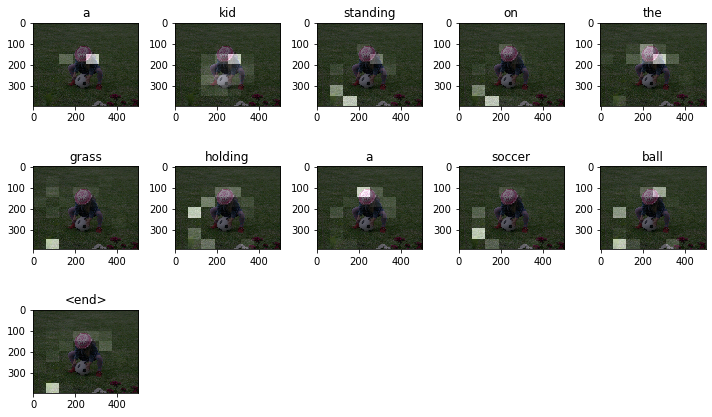

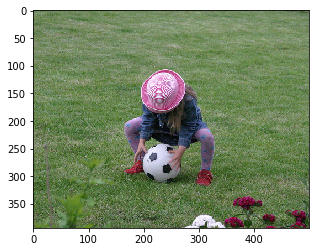

In [43]:
# captions on the validation set
rid = np.random.randint(0, len(val_image_ids))
image_id = val_image_ids[rid]
image_path = os.path.join(PATH, image_id.split('#')[0])
print(image_path)
real_caption = ' '.join([tokenizer.index_word[i] for i in val_cap_vector[rid] if i not in [0]])
result, attention_plot = evaluate(image_path)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
print(attention_plot.shape)
plot_attention(image_path, result, attention_plot)
plot_image(image_path)

## Try it on your own images
For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


Prediction Caption: a surfer rides the waves <end>
6


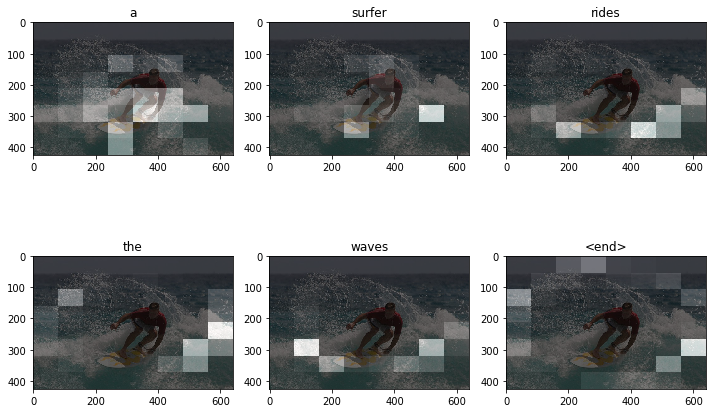

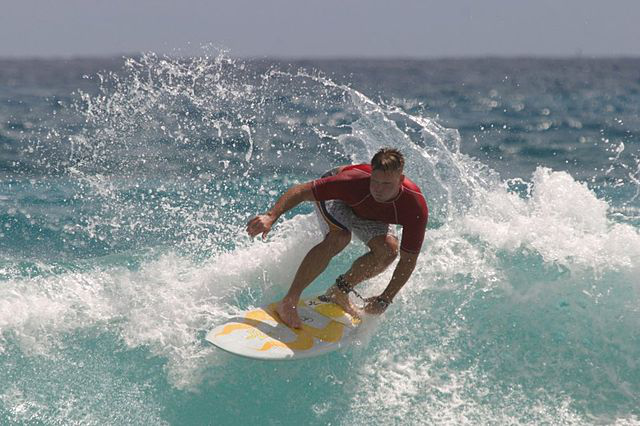

In [46]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

## Additional Exercise

* Experiment with training with more epochs and see if model gives a better caption.
* Download a larger dataset such as Flickr30K or MS COCO.